In [ ]:
# prepare data
import os
import glob
import json
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


paths = list(glob.iglob('data/IJCAI_2019_AAAC_train/*/*'))
for i, p in enumerate(paths):
#     with open(p, 'rb') as f:
#         image_bytes = f.read()
#         image_bytes = exif_remove(image_bytes)
#     iof = BytesIO()
#     iof.write(image_bytes)
    if p.endswith(('gif', )):
        status[i] = False
    image = Image.open(p)
    x, y = image.size
    if x < 30 or y < 30:
        status[i] = False
    if image.format == "GIF":
        status[i] = False
    if image.mode == 'RGBA':
        status[i] = False
    if image.mode != "RGB":
        status[i] = False
status = [True] * len(paths)
paths = np.array(paths)
paths = paths[status]
labels = [int(p.split('/')[-2]) for p in paths]
path_train, path_test, label_train, label_test = train_test_split(paths, labels, test_size=0.2)

In [ ]:
# GAIN API
import cv2
import glob
import torch
import numpy as np
from torch import nn
from PIL import Image
import pretrainedmodels
from matplotlib import pyplot as plt


from config_gain import *
from models import drn, activations
from models.gain import GAINSolver
from models.classifier import ClassifierNet, Classifier

for i in [i / 10 for i in range(-10, 10)]:
# if __name__ == '__main__':
#     i = 0
    backbone = pretrainedmodels.__dict__[model_name]()
    backbone = nn.Sequential(*list(backbone.children())[: -2])
    solver = GAINSolver(backbone, num_classes, in_channels, devices=devices, 
                        activation=activations.HardConcrete(i, temp))
    solver.load_model(
        'saved_models/best_model_GAIN model: se_resnext50_32x4d optimizer: sgd loc: -0.3 temp: 0.1.pt')

    model = pretrainedmodels.__dict__['inceptionresnetv2']()
    net = ClassifierNet(model, 110)
    classifier = Classifier(net, devices=devices)
    classifier.load_model('saved_models/best_model_Classifier model: inceptionresnetv2.pt')

    img = [Image.open(i) for i in glob.iglob('data/dev_data/*') if i.endswith('png')]
    img_np = np.asarray([np.asarray(i) for i in img])

    cls, mask = solver.predict(img)
    mask = mask > 0.5
    img_target = img_np.copy()
    img_target[~mask.repeat(3, axis=-1)] = 0
    num = mask.reshape(mask.shape[0], -1).sum(axis=-1)
    num = num.reshape(mask.shape[0], 1, 1, 1).repeat(3, axis=-1)
    img_mean = img_target.sum(axis=1, keepdims=True).sum(axis=2, keepdims=True) / num
#     img_mean = img_np.mean(axis=1, keepdims=True).mean(axis=2, keepdims=True)
    img_masked = (1 - mask) * img_np + mask * img_mean

    gt = classifier.predict(img).argmax(axis=1)
    pred = solver.predict([Image.fromarray(i) for i in img_masked.astype(np.uint8)])[0].argmax(axis=1)
    true_index = gt == pred
    score = true_index.sum() * 64 / gt.shape[0] + np.sqrt(np.square(img_masked - img_np)[~true_index].mean())
    print('temp: {}, score: {}, acc: {}'.format(i, score, true_index.sum()/110.))

In [1]:
#coding=utf-8
import os
import math
import glob
import tqdm
import torch
from PIL import Image

import pretrainedmodels
from config_gba import *
from models.gradient_based_attack import Attack
from models.classifier import ClassifierNet, Classifier

In [6]:
if __name__ == '__main__':
    os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(map(str, devices))
    models = [pretrainedmodels.__dict__[name]() for name in classifier_name]
    classifiers = [ClassifierNet(model, num_classes) for model in models]
    for c, p in zip(classifiers, classifier_path):
        c.load_state_dict(torch.load(p))
        
    img = [Image.open(i) for i in glob.iglob('data/IJCAI_2019_AAAC_train/00000/*.jpg')][: 16]
    target = [1] * len(img)
    result = []
    epoch = math.ceil(len(img) / batch_size)
    
    solver = Attack(classifiers[: 2], classifiers[: 2], 
                    device='cuda', patience=patience, max_iteration=max_iteration)
    for i in tqdm.tqdm(range(epoch), total=epoch):
        torch.cuda.empty_cache()
        batch_x = img[i * batch_size: (i + 1) * batch_size]
        batch_y = target[i * batch_size: (i + 1) * batch_size]
        result.extend(solver.predict(batch_x, batch_y, targeted, max_perturbation=max_perturbation, lr=lr))

  0%|          | 0/1 [00:00<?, ?it/s]

tensor(105.3271)
tensor(14.4213)
tensor(12.6723)
tensor(14.2668)


100%|██████████| 1/1 [00:30<00:00, 30.12s/it]

tensor(28.9706)


In [7]:
tmp = result[0]

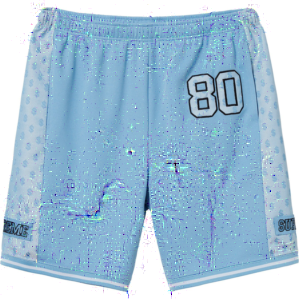

In [8]:
tmp

In [9]:
tmp.save('pics/2.png')